# Spiking Neural Network (SNN) with PyTorch : towards bridging the gap between deep learning and the human brain

> I think I've discovered something amazing: Hebbian learning naturally takes place during the backpropagation of SNNs. Backpropagation in Spiking Neural Networks (SNNs) engenders Spike-Timing-Dependent Plasticity (STDP)-like Hebbian learning behavior.


So:
- At first I simply thought "hey, what about coding a Spiking Neural Network using an automatic differentiation framework?" Here it is. 
- Then I started reading on how to achieve that, such as reading on [Hebbian learning](https://en.wikipedia.org/wiki/Hebbian_theory). Quickly explained: Hebbian learning is somehow the saying that "neurons that fire together, wire together". 
- Then, I think [I've discovered something amazing](https://www.youtube.com/watch?v=Jo6dkHgT6TI). What if when doing backpropagation on a Spiking Neural Network (SNN), Hebbian learning would take place naturally as a side effect of adding that refractory time axis?
- I had the opportunity to discuss that idea with Yoshua Bengio at a conference, and I couldn't get the idea out of my head past that point, so I coded it as follow.
- As a conclusion, I think that the link between deep learning and the human brain is closer than we might think: backpropagation is akin to Hebbian learning. 

If you don't understand what SNNs are, you should watch [this interesting SNN animation](https://www.youtube.com/embed/3JQ3hYko51Y?start=120) which will quickly get you a feel of what it is (especially notice how neurons gets activated only gradually over time like a storm rather than statically from their inputs).

<!-- <iframe width="560" height="315" src="https://www.youtube.com/embed/3JQ3hYko51Y?start=120" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe> -->


## Spiking Neural Networks (SNNs) v.s. Artificial Neural Networks (ANNs)

In SNNs, there is a time axis and the neural network sees data througout time, and activation functions are isntead spikes that are raised past a certain pre-activation threshold. Pre-activation values constantly fades if neurons aren't excited enough. Think of it like a time-distributed ReLU with spikes or nothing at certain time steps. 

Spiking Neural Networks (SNNs) are neural networks that are closer to what happens in the brain compared to what people usually code when doing Machine Learning and Deep Learning. In the case of SNNs, the neurons accumulate the input activation until a threshold is reached, and when this threshold is reached, the neuron empties itself from it's activation and fire. Once empty, it should indeed take some [refractory period](https://en.wikipedia.org/wiki/Refractory_period_(physiology)) until it fires again, as it happen in the brain. 

This implies adding a **time axis** to Artificial Neural Networks (ANNs), where signal is accumulated throughout time in a pre-activation phase, then once a threshold is reached, signal is raised to the neurons above as a firing activation. At every moment, such as when the threshold isn't reached yet, the signal's pre-activation value fades. 

So I roughly replicated this refractory neuron firing pattern behavior here with PyTorch. I coded this without reading existing code for me to try come up with a solution by myself as some kind of challenge and also not to be biased by what others do, building from first principles. I also supposed that throughout time, perceptrons' readings would be noisy to add randomization. As an afterthought, I'm satisfied with what I came up with. 

## Spiking Neural Networks (SNNs) v.s. Recurrent Neural Networks (RNNs)

The SNN is NOT an [RNN](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), despite it evolves through time too. For this SNN to be an RNN, I believe it would require some more connections such as from the outputs back into the inputs. In fact, RNNs are defined as a function of some inputs and of many neurons at the previous time step, such as:

<a href="https://www.codecogs.com/eqnedit.php?latex=$o_t&space;=&space;f(o_{t-1},&space;x_t)$" target="_blank"><img src="https://latex.codecogs.com/gif.latex?$o_t&space;=&space;f(o_{t-1},&space;x_t)$" title="$o_t = f(o_{t-1}, x_t)$" /></a> 

for example. In our case, we keep some state, but it's nothing comparable to having a connection back to other neurons in the past. Forgive me in advance for having appended the suffix "RNN" to my SNN PyTorch class below, as I use it like an RNN with a time axis. But the concept is theoretically different despite they share a common "forward time axis" structure. 


## How does it works?

Okay, let's dive into the details. 

The way I define a neuron's firing method is through the following steps, where the argument `x` is an input:

- Before anything, we need an initialize (or to empty) the state for each neuron upon starting predictions. 
```python
    self.prev_inner = torch.zeros([batch_size, self.n_hidden]).to(self.device)
    self.prev_outer = torch.zeros([batch_size, self.n_hidden]).to(self.device)
```
- Then, a weight matrix multiplies the input x, which in our case is the [handwritten MNIST digits](http://yann.lecun.com/exdb/mnist/). It is to be noted that x was modified to be flickering randomly through time (depending on the intensity of the original input x multiplied by a random uniform noise mask), or else x is already the output of a lower deep spiking layer: 
```python
    input_excitation = self.fully_connected(x)
```
- I then add the result to a decayed version of the information inside the neuron that we already had at the previous time step / time tick (Δt time elapsed). The `decay_multiplier` serves the purpose of slowly fading the inner activation such that we don't accumulate stimulis for too long to be able to have the neurons to rest. The `decay_multiplier` could have a value of 0.9 for example. Decay as such is also called exponential decay and yields an effect of [Exponential moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) over time on the most recent values seen, which also affects the gradients upon backpropagating. So by repeatedly multplying by 0.9 the inner activation through time, it decays and neurons unexcite themselves before firing. In this sense, it's now really true that "neurons that fire together wire together": when a pre-synaptic input is received closer to the moment of giving an output, that recentmost value will not have had the time to be decayed/faded. This way, the gradient of recent neurons that participated in exciting the current neuron that fired will be strong. Learning will be able to take place by gradient descent according to the decay's weightings. So in the opposite case, a stimuli that happened too long ago will suffer from vanishing gradients since it has been exponentially decayed down. So it won't be useful in the learning process of backprop, which is what we want and respects the "neurons that fire together, wire together" idiom of Hebbian learning. 
```python
    inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
```
- Now, we compute the activation of the neurons to find their output value. We have a threshold to reach before having the neuron activating. The ReLU function might not be the most appropriate here (more on that later), but I wanted to get a working prototype fast: 
```python
    outer_excitation = F.relu(inner_excitation - self.threshold)
```
- Now, magic happens. If the neuron fires, the activation of the neuron is *subtracted to its inner state* to reset each neuron. First, this has the effect of resetting them to a resting position such that they won't be firing constantly upon being activated once. Second, resetting them as such will clip the gradient through time to isolate each firing events from each other. SNNs as such are truly inspired from the brain, as the natural neurons also have a refractory period: neurons, once they fire, will need to wait a bit before firing again even if fully excited by lower neurons they have as inputs. So here, I even subtracted a second penalty named `penalty_threshold` after each resetting `threshold`. Disclaimer: I wasn't sure whether the negative part in the biological refractory period was on the outputs of the neurons or inside the neurons (e.g.: axon v.s. body?), so here I've simply put it inside. Let's see how I subtract this just when the neuron fires to have it to have a refractory period: 
```python
    do_penalize_gate = (outer_excitation > 0).float()
    inner_excitation = inner_excitation - (self.penalty_threshold + outer_excitation) * do_penalize_gate
```
- Finally, I return the previous output, simulating a small firing delay, which is useless for now, but which may be interesting to have if the SNN I coded was ever to have Recurrent connections which would require time offsets in the connections from top layers near the outputs back into bottom layers near the input: 
```python
    delayed_return_state = self.prev_inner
    delayed_return_output = self.prev_outer
    self.prev_inner = inner_excitation
    self.prev_outer = outer_excitation
    return delayed_return_state, delayed_return_output
```
- Past that, to do the classification, the values of the classification output spiking neurons are averaged over the time axis so as to have one number per class to plug into the softmax cross entropy loss for classification as we know it and we backpropagate. This means the present SNN PyTorch class is reusable within any other feedforward neural network, as it repeats intputs over time with random noisy masks, and averages outputs over time.  

Amazingly, it worked on the 1st try once the dimension mismatching errors were fixed. And the accuracy was about the same of the accuracy of a simple non-spiking Feedforward Neural Network with the same number of neurons. And I didn't even tuned the threshold. In the end, I realized that coding and training a Spiking Neural Network (SNN) with PyTorch was easy enough as shown above, it can be coded in an evening as such. 



Basically, the neurons' activation must decay through time and fire only when getting past a certain threshold. So I've gated the output of the 


## Results

Scroll on! Nice visuals awaits.


In [1]:
import os

import matplotlib.pyplot as plt

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


In [2]:

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))

def train_many_epochs(model): 
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
            
def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set


In [3]:
batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

In [4]:
# Use GPU whever possible!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)


class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

## Training a Spiking Neural Network (SNN)

Let's use our `SpikingNet`!

In [6]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.460052 Accuracy: 9.90%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.811235 Accuracy: 30.00%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.797833 Accuracy: 38.60%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.645438 Accuracy: 83.30%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.522837 Accuracy: 83.50%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.528960 Accuracy: 81.80%

Test set: Average loss: 0.0004, Accuracy: 8955/10000 (89.55%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.405339 Accuracy: 87.80%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.357420 Accuracy: 88.80%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.326266 Accuracy: 90.10%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.377100 Accuracy: 89.60%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.335625 Accuracy: 90.60%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.359532 Accuracy: 88.90%

Test set: Average loss: 0.0003, Accuracy: 9061/10000 (90.61%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.342230 Accuracy: 90.40%
Train Epoch: 3 [1

## Training a Feedforward Neural Network (for comparison)

It has the same number of layers and neurons, and also uses ReLU activation, but it's not an SNN, this one is a regular one as defined in the code above with this other class `NonSpikingNet`.

In [7]:
non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.300953 Accuracy: 9.50%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.908515 Accuracy: 62.40%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.259780 Accuracy: 72.20%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.861031 Accuracy: 83.00%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.652988 Accuracy: 85.40%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.609710 Accuracy: 84.40%

Test set: Average loss: 0.0005, Accuracy: 8691/10000 (86.91%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.469882 Accuracy: 88.30%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.479579 Accuracy: 85.80%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.466115 Accuracy: 88.20%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.479764 Accuracy: 87.10%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.472486 Accuracy: 85.50%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.443070 Accuracy: 88.20%

Test set: Average loss: 0.0004, Accuracy: 8880/10000 (88.80%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.432652 Accuracy: 88.20%
Train Epoch: 3 [1

## Let's see how the neurons spiked

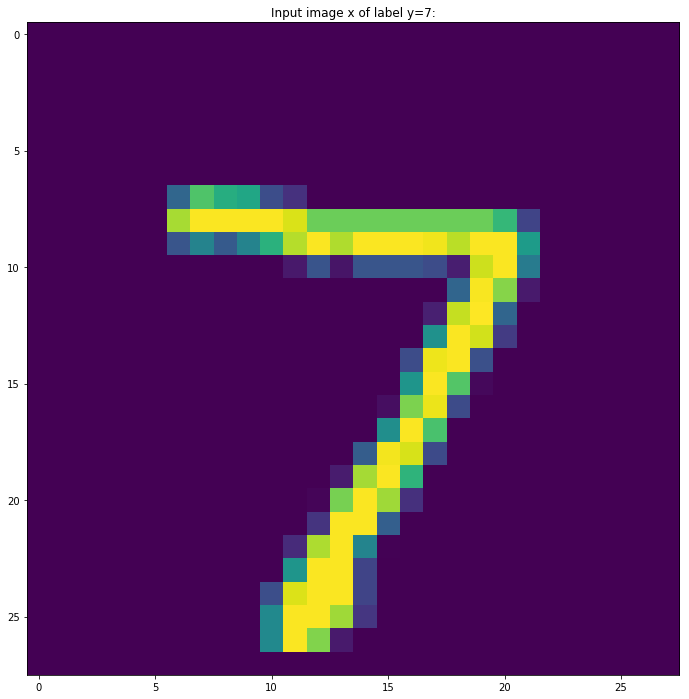

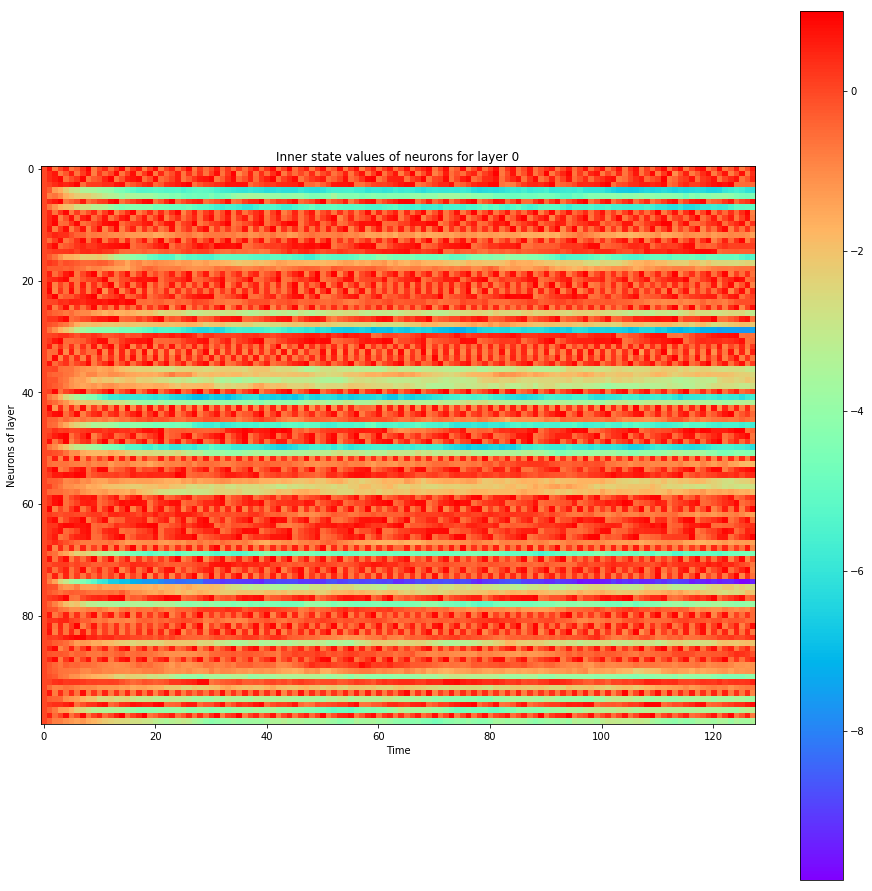

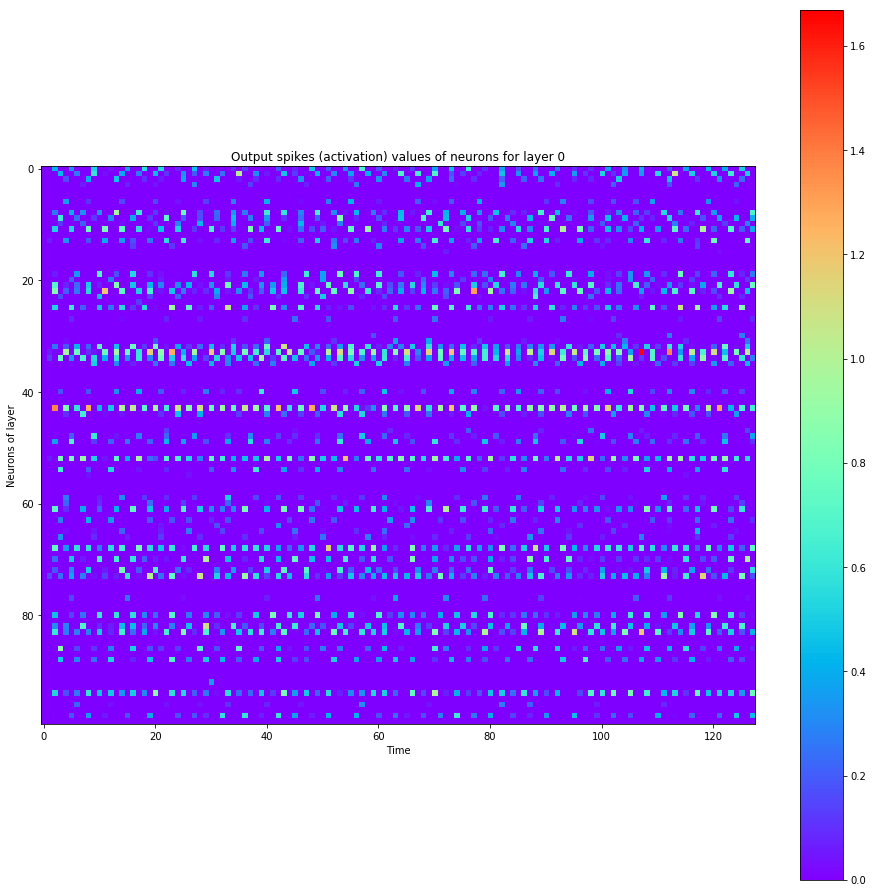

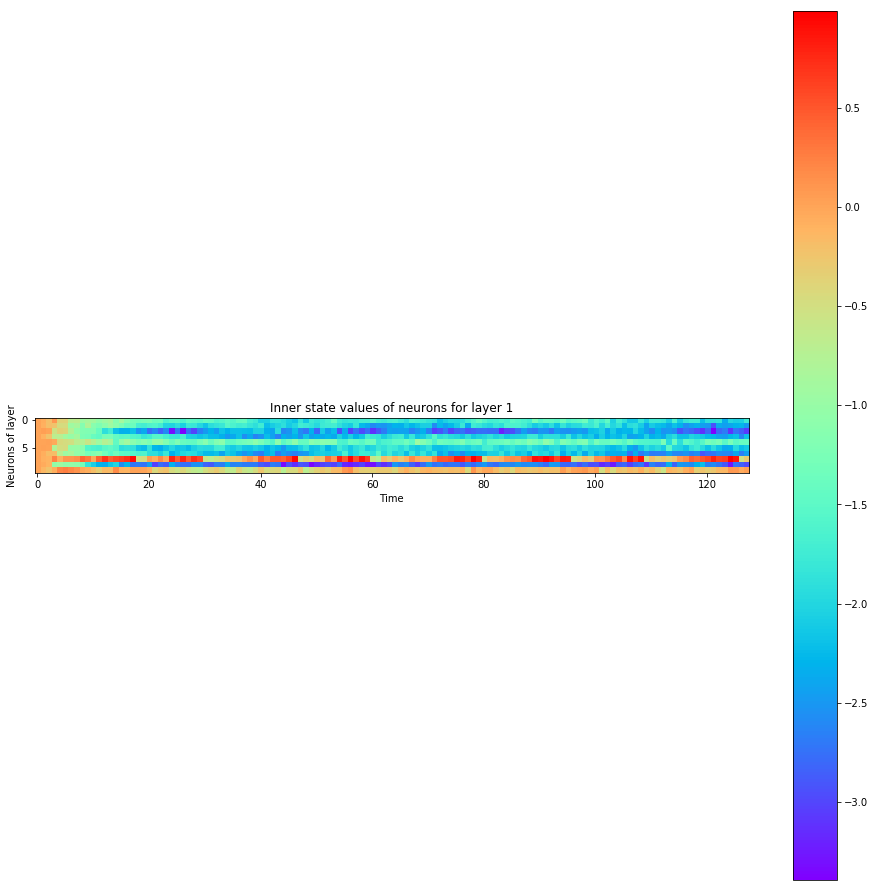

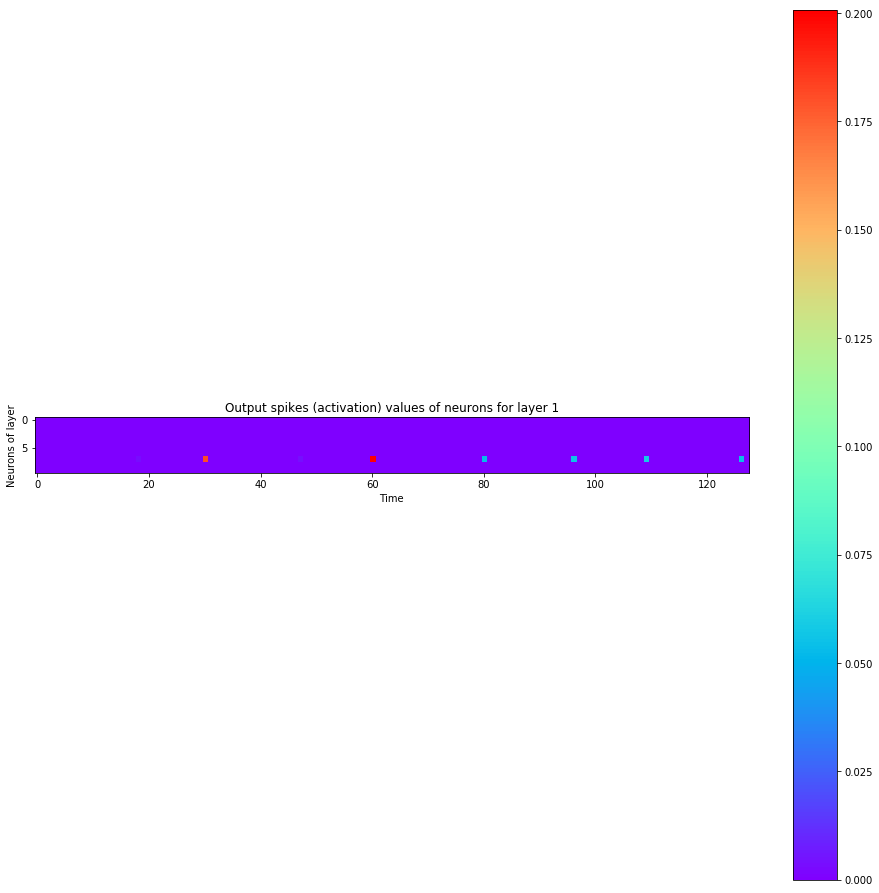

A hidden neuron that looks excited:


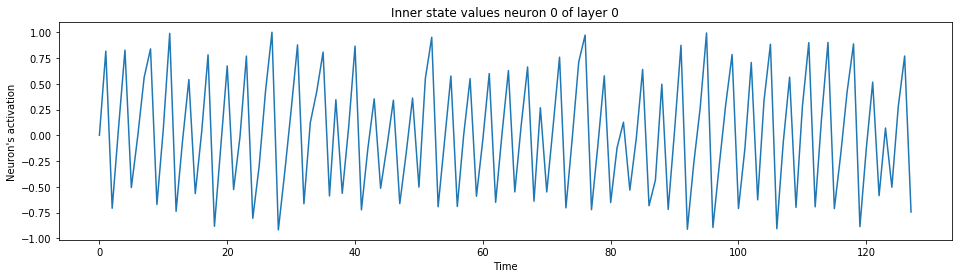

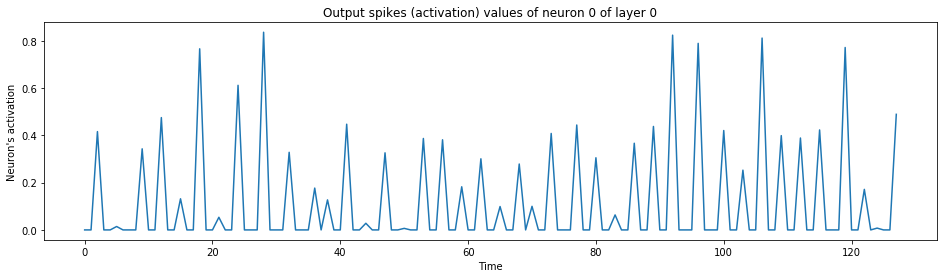

The output neuron of the label:


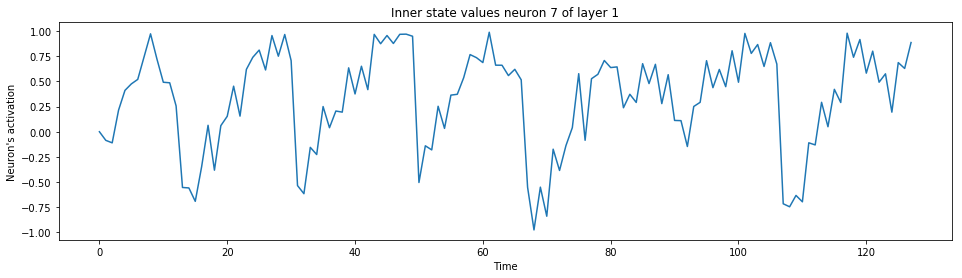

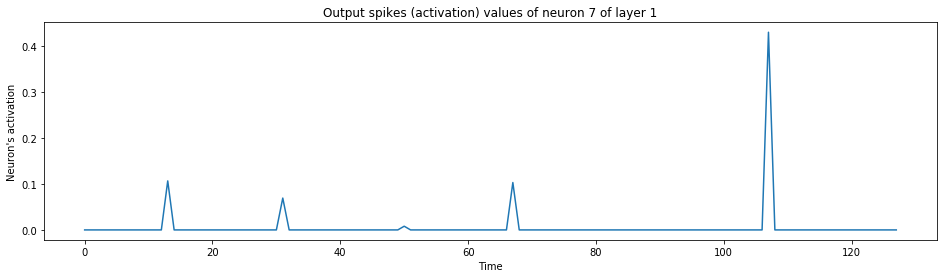

In [8]:
data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]]) 
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

## Discussion

Well, I've trained just a bit here. My goal is not to break the benchmarks, I just wanted to make a comparison and to see if it could train. So it ends up that the results are about the same, however the SNN seems to perform a bit better, although it takes much more time to train. 

Full disclaimer: no to almost no hyperparameter tuning has been performed yet as I've coded this mostly one-shot and posted it, so the performances may vary a lot with tinkering. It would be worth trying a few more things to see how it goes (don't hesitate to fork the [repo](https://github.com/guillaume-chevalier/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP)). 

Using SNNs should act as a regularizer, just like dropout, as I wouldn't expect the neurons to fire all at the same time. Although, I want to point out that it's an interesting path to explore, as [Brain Rhythms](https://www.youtube.com/watch?v=OCpYdSN_kts) seems to play an important role in the brain, whereas in Deep Learning no such things happens. 

I think that I've discovered that backpropagation can entail Hebbian learning given a time axis and a refractory firing behavior on that time axis within Deep Neural Networks (DNN). Although I have searched online and I **haven't found** anyone explaining this link concretely, so this is why I want to explain it as follow, as it might be the first time that this is written down in words. If you found prior art, [please open an issue](https://github.com/guillaume-chevalier/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP/issues). 

## An interesting idea: Hebbian learning naturally takes place in the backpropagation of SNNs

Before even explaining what I discovered and how all of this relates, a little bit of theory is needed here. 

### Introduction to Hebbian theory and Spike-Timing-Dependent Plasticity (STDP)

First, what is Hebbian Theory? In simple words, neurons that fire together wire together. More precisely, let's see how [it is explained on Wikipedia](https://en.wikipedia.org/wiki/Hebbian_theory) here: 

> #### Hebbian theory
> 
> Hebbian theory is a neuroscientific theory claiming that an increase in synaptic efficacy arises from a presynaptic cell's repeated and persistent stimulation of a postsynaptic cell. It is an attempt to explain synaptic plasticity, the adaptation of brain neurons during the learning process. It was introduced by Donald Hebb in his 1949 book The Organization of Behavior.[1] The theory is also called Hebb's rule, Hebb's postulate, and cell assembly theory. Hebb states it as follows:
> 
> > Let us assume that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability.[…] When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A's efficiency, as one of the cells firing B, is increased.[1]
>
> The theory is often summarized as "Cells that fire together wire together."[2] This summary, however, should not be taken too literally. Hebb emphasized that cell A needs to "take part in firing" cell B, and such causality can occur only if cell A fires just before, not at the same time as, cell B. This important aspect of causation in Hebb's work foreshadowed what is now known about [spike-timing-dependent plasticity](https://en.wikipedia.org/wiki/Spike-timing-dependent_plasticity), which requires temporal precedence.[3] [...]

Let's pause here. What is Spike-Timing-Dependent Plasticity (STDP)? From [Wikipedia, here is how it is explained](https://en.wikipedia.org/wiki/Spike-timing-dependent_plasticity):

> #### Spike-timing-dependent plasticity
> 
> Spike-timing-dependent plasticity (STDP) is a biological process that adjusts the strength of connections between neurons in the brain. The process adjusts the connection strengths based on the relative timing of a particular neuron's output and input [action potentials](https://en.wikipedia.org/wiki/Action_potential) (or spikes). The STDP process partially explains the activity-dependent development of nervous systems, especially with regard to [long-term potentiation](https://en.wikipedia.org/wiki/Long-term_potentiation) and [long-term depression](https://en.wikipedia.org/wiki/Long-term_depression).
>
> [...]
>
> ##### History
> 
> In 1973, M. M. Taylor[1] suggested that if synapses were strengthened for which a presynaptic spike occurred just before a postsynaptic spike more often than the reverse (Hebbian learning), while with the opposite timing or in the absence of a closely timed presynaptic spike, synapses were weakened (anti-Hebbian learning), the result would be an informationally efficient recoding of input patterns. This proposal apparently passed unnoticed in the neuroscientific community, and subsequent experimentation was conceived independently of these early suggestions.
> [...]
> In studies on neuromuscular synapses carried out by Y. Dan and Mu-ming Poo in 1992,[3] and on the hippocampus by D. Debanne, B. Gähwiler, and S. Thompson in 1994,[4] showed that asynchronous pairing of postsynaptic and synaptic activity induced long-term synaptic depression.
> [...]
> Several reasons for timing-dependent plasticity have been suggested. For example, STDP might provide a substrate for Hebbian learning during development,[7][8] or, as suggested by Taylor[1] in 1973, the associated Hebbian and anti-Hebbian learning rules might create informationally efficient coding in bundles of related neurons.
> 
> ##### Mechanisms
> 
> [...] Due to their high permeability for calcium, they generate a local chemical signal that is largest when the [back-propagating action potential](https://en.wikipedia.org/wiki/Neural_backpropagation) in the dendrite arrives shortly after the synapse was active (pre-post spiking). Large postsynaptic calcium transients are known to trigger synaptic potentiation (Long-term potentiation). The mechanism for spike-timing-dependent depression is less well understood, but often involves either postsynaptic voltage-dependent calcium entry/mGluR activation [...].
> 
> ##### From Hebbian rule to STDP
> 
> According to the Hebbian rule, synapses increase their efficiency if the synapse persistently takes part in firing the postsynaptic target neuron. An often-used simplification is those who fire together, wire together, but if two neurons fire exactly at the same time, then one cannot have caused, or taken part in firing the other. Instead, to take part in firing the postsynaptic neuron, the presynaptic neuron needs to fire just before the postsynaptic neuron. Experiments that stimulated two connected neurons with varying interstimulus asynchrony confirmed the importance of temporal precedence implicit in Hebb's principle: the presynaptic neuron has to fire just before the postsynaptic neuron for the synapse to be potentiated.[10] In addition, it has become evident that the presynaptic neural firing needs to consistently predict the postsynaptic firing for synaptic plasticity to occur robustly,[11] mirroring at a synaptic level what is known about the importance of contingency in classical conditioning, where zero contingency procedures prevent the association between two stimuli.

You might now see where I'm going with all those definitions.

## Backpropagation engenders Hebbian learning

Okay, let's proceed with the explanations. One element is missing from the above title. I should rather say, "Backpropagation engenders Hebbian learning when dealing with SNNs". SNNs are here the mathematical tool that enables doing the proof and making the link. Why? Because the concept of timing in STDP is important for going from backpropagation to Hebbian learning. 

Think about it: from the point of view of a neuron that spikes, upon performing backpropagation, the neuron will backpropagate to its inputs for which the input signal was received more recently than not, hence the signal that really contributed to firing. Why? Because older signals are decayed exponentially and their gradients vanish towards zero. So with SNNs, the gradients are mostly transferred to input that was fired just before self-firing to an output from the point of view of a neuron. 

However, there is still a mystery. 
- First, the gradient could still be negative despite the neurons did fire together. This doesn't mean that the behavior or the neuron that provoked the firing of another neuron will be necessarily reinforced positively. If you have any additional ideas on this, please open an [issue](https://github.com/guillaume-chevalier/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP/issues). 
- Second, if the input neuron fires just after instead of just before, its gradient remains unnafected or will have strongly decayed later on. To fix this second point, I at least have two ideas on how a neuron that fired too late could be penalized: 
  - Use weight decay (L2) regularization, or
  - Have neurons output a small negative signal shortly after the positive signal, and let this negative signal be longer than the positive signal (such that the integral of the whole spike and its negative following counterpart would be null or close to null) and let this negative signal be provoked by the late neurons's signal such that their late signal be the one penalized during backpropagation.

All of that said, this is a very interesting link between the saying of "cells that fire together wire together" (Hebbian learning) and backpropagation. Think about it. 

### How is backpropagation implemented in the brain? Could it be Contrastive Divergence (CD) between the brain rhythms' cycles?

The question is as asked by Yoshua Bengio: https://youtu.be/FhRW77rZUS8?t=19m47s

First, let me point to you at the 35th minute of [this talk](https://youtu.be/VIRCybGgHts?t=35m17s) of Geoffrey Hinton. STDP is discussed, and earlier in the talk, Hinton did talk about **autoencoders** doing **cycles**. To me, those cycles weirdly resembles [Brain Rhythms](https://www.youtube.com/watch?v=OCpYdSN_kts). This leads me to my next idea: **what if** brain rhythms were those cyclic autoencoder passes (as discussed by Hinton), between which the past and new information was compared to generate purely local gradients? The link between the two concepts seems small, but I feel like it could somehow be very very related and an important topic.

> Cool idea: what if in the brain, gradients comes from Contrastive Divergence (CD) between each brain rhythm iteration?

That seems like an intersting conjecture to me. It would be interesting to try. So the differences of activation values between brain rhythms (as CD is done in autoencoders) could act as a learning signal to help auto-encode information in an unsupervised manner. First, we humans are born as unsupervised machines (or perhaps more semi-supervised machines learning to minimize pain). 

CD is the algorithm that is used in autoencoders such as the Restricted Boltzmann Machines (RBM), such that passing the information in the neurons as a cycle enables differentiating signals to structure information into clusters and categories. Have you ever classified someone new in one of your stereotype "boxes"? That might be the result of clusters of unsupervised learning.

Imagine for a second a deep SNN for which the top-most layer would feed back into the lower-most layer, and that CD is used to assist learning into discovering patterns just like what's done in Restricted Boltzmann Machines (RBM). This way you might already find powerful gradients provided by the CD which may help the neural network lear by himself just seeing data - even before having a precise supervised learning goal (gradient) being provided.

There could also be cycles of cycles. So you could have high-frequency SNN CD cycles, and low-frequency ones using more layers between the cycles. This way each small layer can tune himself, but also the big picture also syncs up, having the top-most layers re-feeding back into other parts of the network. 

### Other tracks that were pointed out by Yoshua Bengio to explore 

I have talked to Yoshua Bengio on this topic of the discovery I've made on how that backprop could entail Hebbian learning in the brain. Among other thing, he pointed me to a few learning resources on this precise topic (and also to read a paper a day), so I asked for what to read on the topic. 
- First, he named Blake Richard. 
- Then, he named Walter Senn.
- He also named Konrad Kording. 

Watching [this video of Blake Richard](https://youtu.be/C_2Q7uKtgNs?t=11m3s), at about 11 minutes, he says that he have been thinking for a long time on how the brain could do backpropagation or something similar to it. And he says that in Deep Learning, we have stripped the complexity out of the neurons and that real neurons are way more complicated than neurons used in Deep Learning. He even says that perhaps by stripping away the complexity, we have made things harder to understand. Later when he describes his work, he talks of approximating the weight updates that would be prescribed by backpropagation in his algorithm. From what he says about ensembles later on in the talk, it looks like a good idea, especially when dealing with SNNs. Those ensembles are like having many neurons playing the role of one neuron (somehow like trees v.s. forests). I thought about that simply to provide more spikes per "neuron", where a "neuron" would now instead be a neuron ensemble with similar weights, but didn't see it as a way to share the gradient of the whole group of neurons. It could be interesting to attribute a backpropagated gradient to such an ensemble of neurons instead of just one, because SNNs' spikes are rarer than continuous sigmoid-activated output. This could avoid dead neurons (think like dead ReLUs but in SNNs because of lack of spiking). It would somehow be possible to "cheat" the gradients by normalizing the sum of all inner states to the sum of the amplitude of the output activations to attribute some of the gradients back to all neurons of the ensemble if one of the neurons of the ensemble fires. Interesting fact: this also makes me think of capsules networks with their voting groups of neurons.  

Despite the work I present here successfully trained on the first shot after coding and debugging dimensions, I have been tempted to code an ensemble myself. What surprises me is that I've coded the present SNN before watching Blake's video, but in a different way (which I have rollbacked due to too much added complexity to this already-complex code which would make it too unreadable to you open-source code reader - oops sorry I didn't even commit it). So first, I tried to use output neurons' activation instead of their inner state as logits. 

One thing that struck me is that it would never learn what to do for a label if the label was never firing (like a dead neuron): the gradients would never reach the teaching signal if the neural net was badly initialized from random. This lead me to create an ensemble of neurons for each label, which now as of writing makes me thing of the [Mixture of Softmaxes (MoS)](https://smerity.com/articles/2017/mixture_of_softmaxes.html) in which many softmaxe layers are used a the output, and which is similar to having an ensemble of neurons at the output. With such modifications, the network could learn. Also, I tried to add a 3rd layer such as to have one more hidden layer as currently. This at first didn't work and required to adjust carefully the firing thresholds for every neuron not to be already dead at the start (especially in the top layers, no information was received - just [this interesting SNN animation](https://www.youtube.com/embed/3JQ3hYko51Y?start=120) - SNNs probably needs some tuning to ensure neurons doesn't end up dead easily). 


## Conclusion

I am not the first one to program an SNN for sure, although those kind of neural networks are rarily coded. However, I expose here some important behavior that emerges from using SNNs where each neuron has its excitation evolving through time and then spiking, linking to interesting resources, and providing dynamic PyTorch code as an example on how to work with SNNs. 

I lay out the foundations for thinking that STDP and Hebbian learning are closely related to backpropagation in SNNs. Backpropagation in SNNs could engender the STDP rule like in Hebbian learning, as in SNNs the inner pre-activation value fades until it reaches a threshold and fire, which makes old pre-activation values fade with a vanishing gradient to enforce STDP. 

It is also interesting that brain rythms could happen in SNNs, and that with Contrastive Divergence (CD), gradients could be provided between each cycle of the rhythm to enhance formation of clusters in the representation of information in the neurons, unsupervised learners that we humans are. I also point out to an idea of having a negative spike right after each positive spike, where negative spikes are inversely correlated to pre-synaptic neurones that fired too late for the impulse to be released so as to improve timing or respect more the rule of STDP that neurons late to the party should be penalized and would instead need to fire before their post-synaptic target.

## Citation

I'm somehow not sure of the importance of my discovery of the link between STDP, Hebbian learning and backpropagation, as it might have already been discovered before, although I didn't find prior art. I did this on my own as a side project purely out of curiosity. I'd like to see dicussion in the [issues](https://github.com/guillaume-chevalier/Spiking-Neural-Network-SNN-with-PyTorch-where-Backpropagation-engenders-STDP/issues) section on GitHub. I should perhaps write a paper if this article gets traction. For the time being, to cite my code, you can point to the URL of the GitHub repository, for example:

> Guillaume Chevalier, Spiking Neural Networks (SNNs) with PyTorch, 2018,
> https://github.com/guillaume-chevalier/Spiking-Neural-Networks-SNNs-with-PyTorch

## License

Copyright (c) 2019 Guillaume Chevalier. 

The present article's text is available under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

My source code in the present article is not available yet under a license, but it's super fine to use it for educational or research purposes as long as you cite. 

## Keep in touch!

I frequently code open-source and source-available repositories, either from work or for fun. Also check out out my new [Machine Learning Pipeline library](https://github.com/Neuraxio/Neuraxle) for easily coding automatic machine learning pipelines. 

### Connect with me

- [LinkedIn](https://ca.linkedin.com/in/chevalierg)
- [Twitter](https://twitter.com/guillaume_che)
- [GitHub](https://github.com/guillaume-chevalier/)
- [Quora](https://www.quora.com/profile/Guillaume-Chevalier-2)
- [YouTube](https://www.youtube.com/c/GuillaumeChevalier)
- [Do R&D/Consulting/Products with me](http://www.neuraxio.com/en/)

Liked this project? Did it help you? Leave a [star](https://github.com/guillaume-chevalier/Spiking-Neural-Networks-SNNs-with-PyTorch/stargazers), [fork](https://github.com/guillaume-chevalier/Spiking-Neural-Networks-SNNs-with-PyTorch/network/members) and share the love!


In [9]:
# Let's convert this notebook to a README automatically for the GitHub project's title page:
!jupyter nbconvert --to markdown "Spiking Neural Networks with PyTorch.ipynb"
!mv "Spiking Neural Networks with PyTorch.md" README.md

[NbConvertApp] Converting notebook Spiking Neural Networks with PyTorch.ipynb to markdown
[NbConvertApp] Support files will be in Spiking Neural Networks with PyTorch_files/
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Making directory Spiking Neural Networks with PyTorch_files
[NbConvertApp] Writing 50412 bytes to Spiking Neural Networks with PyTorch.md
